# Exploring Convergence of MCMC Simulations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate
from scipy.stats import gaussian_kde

Import results from an MCMC simluation. We'll take results from HD 189733.

In [2]:
flatchain = np.genfromtxt('data/HD189733_W0300_N0300_B0000.dat')

Reconstruct the original chains by reshaping the flattened chain.

In [3]:
chains = flatchain.reshape(300, -1, flatchain.shape[1])

We can start with a simple trace plot of the various parameters in the MCMC run for all of the chains (at once).

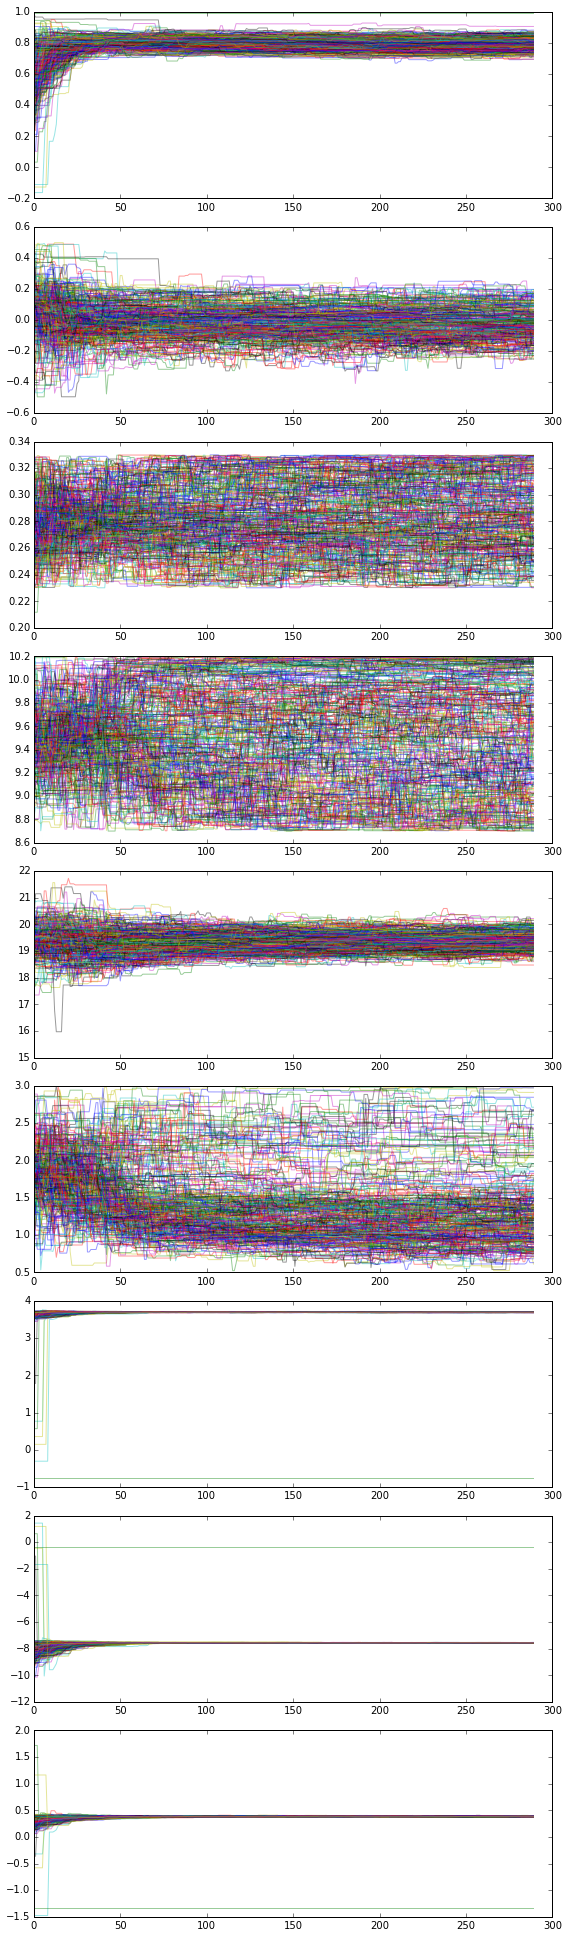

In [4]:
fig, ax = plt.subplots(chains.shape[2], 1, figsize=(8., chains.shape[2]*3.))

for i, axis in enumerate(ax):
    for j in range(chains.shape[0]):
        axis.plot(chains[j, :, i], '-', alpha=0.4)
fig.tight_layout()

We can also visualize the trace plots as a running average.

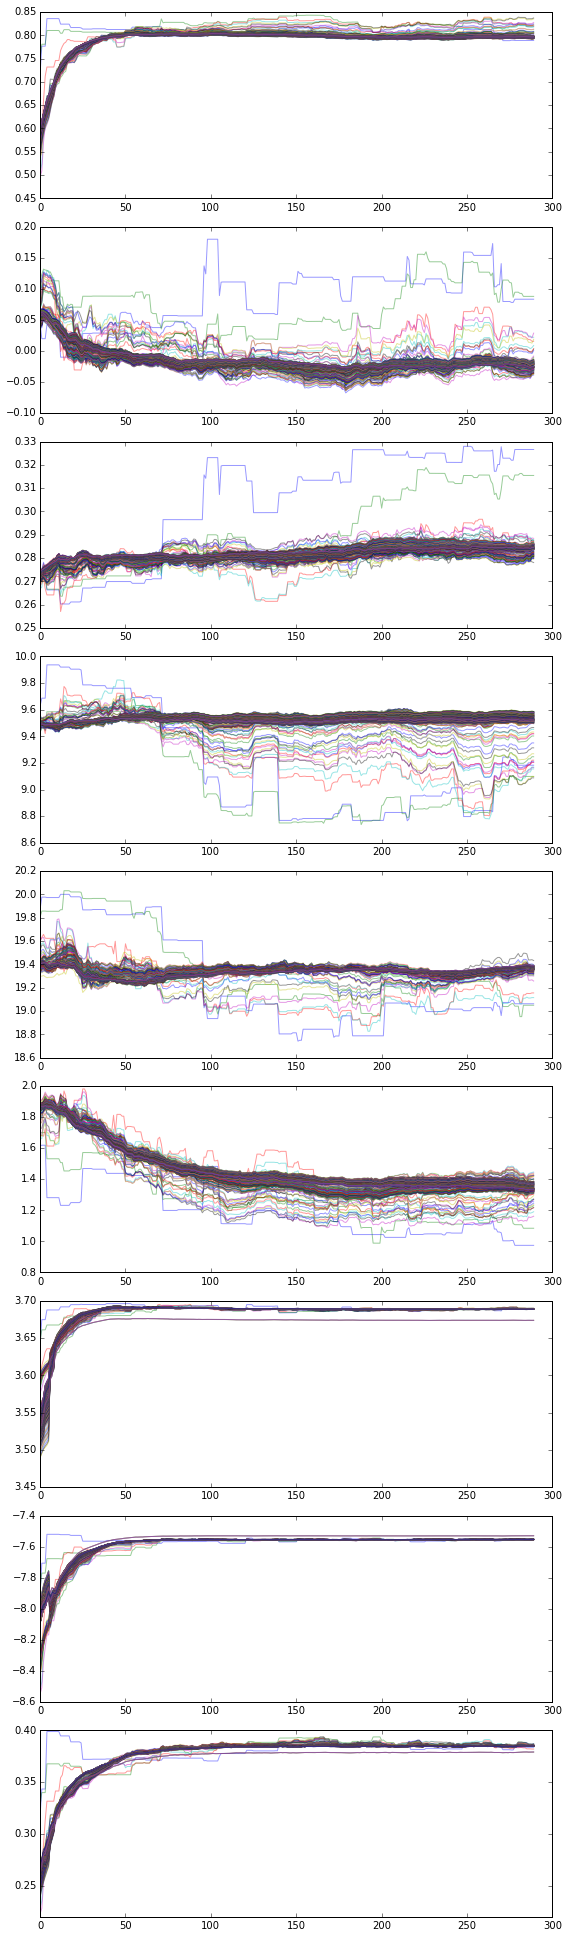

In [5]:
fig, ax = plt.subplots(chains.shape[2], 1, figsize=(8., chains.shape[2]*3.))

# compute running averages
running_mean = np.array([np.mean(chains[:i, :, :], axis=0) for i in range(1, chains.shape[0])])

for i, axis in enumerate(ax):
    for j in range(running_mean.shape[0]):
        axis.plot(running_mean[j, :, i], '-', alpha=0.4)
fig.tight_layout()

We can also try computing the autocorrelation function.

In [6]:
# compute ACF for just a single chain, say chain 120
chain = 120
means = np.mean(chains[chain], axis=0)
   
acf = np.empty((250, 9))
for k in range(250):
    numerator = 0.
    denominator = 0.
     
    for j in range(chains[chain].shape[0] - k):
        numerator += ((chains[chain, j] - means)*(chains[chain, j + k] - means))
            
    for j in range(chains[chain].shape[0]):
        denominator += (chains[chain, j] - means)**2
        
    acf[k] = numerator/denominator

Now we can plot the autocorrelation as a function of lag.

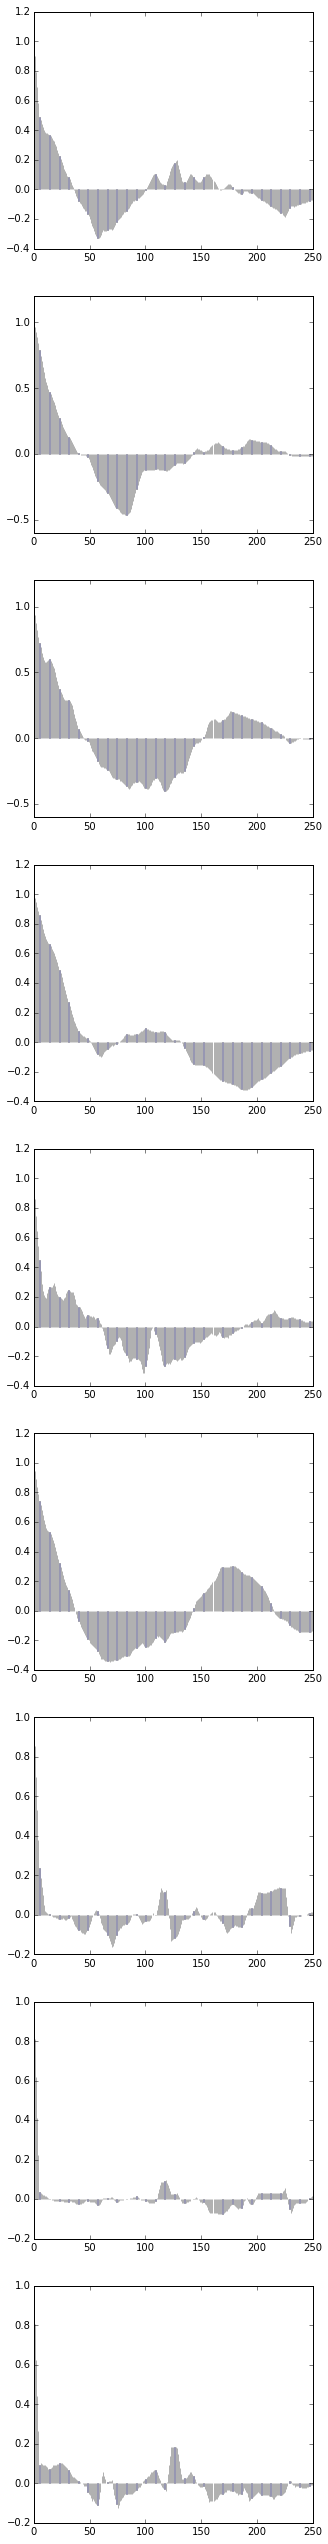

In [7]:
fig, ax = plt.subplots(9, 1, figsize=(5., 9*5.))

for i, axis in enumerate(ax):
    axis.bar(np.arange(0., 250., 1.), acf[:, i], 0.1, alpha=0.3)

The above shows the autocorrelation as a function of phase lag. We see that the samples are not highly correlated, at least in this particular chain. After a lag of about 10 to 25 iterations, the autocorrelation function falls below 0.4 and then remains low for larger lags. The chain that shows the largest correlation is that for the helium abundance (panel 3), which is not constrained in this partiuclar run.

It may be possible to derive an effective sample size for this particular chain, based on the lag autocorrelation funciton.

In [8]:
chains[chain].shape[0]/(1. + 2.*np.sum(acf, axis=0))

array([ 115.28081327,   72.96519503,   97.41205092,   64.1293427 ,
        578.37731441,   30.03539558,   59.86636733,   65.399825  ,
         65.33964534])

Ultimately, we find that the samples for this chain represent of order 100 independent samples of the posterior distribution. For parameters like the mixing length, however, the effective number of samples is significantly less (~ 30).

However, we should be interested in the "autocorrelation time," which for this particular chain is

In [9]:
1. + 2.*np.sum(acf, axis=0)

array([ 2.51559641,  3.9744977 ,  2.97704439,  4.52211091,  0.50140279,
        9.65527487,  4.84412222,  4.43426263,  4.43834671])

Or only a few iterations. In practice, we would like to perform an MCMC simulations for several 10s of autocorrelation times. Since the largest autocorrelation time is about 10 iterations, approximately 100 iterations is a suitable number of simulation iterations.

Looking at the autocorrelation times for each chain, we can plot the distribution of autocorrelation times to see how well our simulations has performed.

In [10]:
# compute ACF for just a single chain, say chain 120
Nlag = 250
acf = np.empty((chains.shape[0], Nlag, chains.shape[-1]))

for n, chain in enumerate(chains):
    means = np.mean(chain, axis=0)
    
    for k in range(Nlag):
        numerator = 0.
        denominator = 0.
     
        for j in range(chains[n].shape[0] - k):
            numerator += ((chains[n, j] - means)*(chains[n, j + k] - means))
            
        for j in range(chains[n].shape[0]):
            denominator += (chains[n, j] - means)**2
        
        acf[n, k] = numerator/denominator

In [11]:
autocorr_times = 1. + 2.*np.sum(acf, axis=1)

In [12]:
np.mean(autocorr_times, axis=0)

array([ 5.50495076,  5.80532971,  4.89953665,  5.59833281,  5.41999895,
        6.68911412,  5.81197531,  6.74215662,  7.82238908])

In [13]:
np.median(autocorr_times, axis=0)

array([ 4.39686999,  4.21176429,  3.70207792,  4.95897158,  3.87314656,
        6.62731801,  4.97416041,  6.39839177,  7.24689204])

In [14]:
autocorr_times = np.array([line for line in autocorr_times if line[0] < 100.])
print("{0:3.0f} chain(s) have been removed.".format(300 - autocorr_times.shape[0]))

  1 chain(s) have been removed.


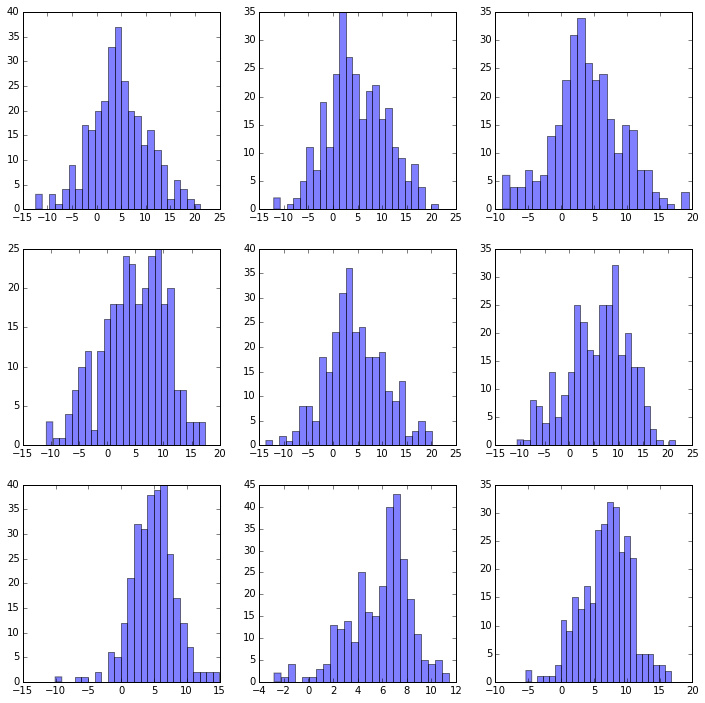

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(12., 12.))

for i in range(9):
    row = i/3
    col = i%3
    
    tmp = ax[row, col].hist(autocorr_times[:, i], bins=25, alpha=0.5)

We can see from the above series of histograms that most of the autocorrelation lengths/times peak between 5 - 10 iterations. Since, it is important that we run the simluations for 10 autocorrelation times or more, we would like to run the simulations for about 50 to 100 iterations, which we have done with our simluations. 

Based on the autocorrelation times and visual monitoring via trace plots, our simluation length of 300 iterations with 300 walkers is sufficient to provide an estimate of the target distributions for the parameters of HD 189733. It is always possible that further evolution of the chains would occur over larger simluations, but the walkers have seemingly settled on reasonable posterior distributions for the parameters.